In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, activations

# -----------------------------
# Multi-Head Self-Attention
# -----------------------------
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        assert dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads

        self.query = layers.Dense(dim)
        self.key = layers.Dense(dim)
        self.value = layers.Dense(dim)
        self.out = layers.Dense(dim)

In [2]:
def call(self, x):
        B = tf.shape(x)[0]
        N = tf.shape(x)[1]
        D = x.shape[-1]
        H = self.num_heads
        d = self.head_dim

        # Linear projections
        Q = tf.reshape(self.query(x), (B, N, H, d))
        K = tf.reshape(self.key(x), (B, N, H, d))
        V = tf.reshape(self.value(x), (B, N, H, d))

        Q = tf.transpose(Q, perm=[0, 2, 1, 3])  # (B, H, N, d)
        K = tf.transpose(K, perm=[0, 2, 1, 3])
        V = tf.transpose(V, perm=[0, 2, 1, 3])

        # Scaled Dot-Product Attention
        attn_score = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(d, tf.float32))
        attn_weight = tf.nn.softmax(attn_score, axis=-1)
        attn_out = tf.matmul(attn_weight, V)  # (B, H, N, d)

        # Concat heads
        attn_out = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (B, N, H, d)
        attn_out = tf.reshape(attn_out, (B, N, D))  # (B, N, D)
        return self.out(attn_out)

In [3]:
# -----------------------------
# ResNet Block
# -----------------------------
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = layers.Conv1D(channels, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1D(channels, 3, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x, training=False):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = out + residual
        return self.relu(out)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ----------------------------------------
# 1. ResNet 블록 정의 (원래 코드 그대로 사용)
# ----------------------------------------
class ResNetBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3):
        super().__init__()
        self.conv1 = layers.Conv1D(filters, kernel_size, padding='same', activation='relu')
        self.conv2 = layers.Conv1D(filters, kernel_size, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.shortcut = layers.Conv1D(filters, 1, padding='same')
        self.relu = layers.ReLU()

    def call(self, inputs, training=False):
        shortcut = self.shortcut(inputs)
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x += shortcut
        x = self.relu(x)
        return x

# ----------------------------------------
# 2. ResNet만 사용하는 전체 모델
# ----------------------------------------
class ResNetOnly(Model):
    def __init__(self, input_dim, hidden_dim, num_classes, num_blocks=3):
        super().__init__()
        self.fc0 = layers.Dense(hidden_dim)
        self.resnet_blocks = [ResNetBlock(hidden_dim) for _ in range(num_blocks)]
        self.global_pool = layers.GlobalAveragePooling1D()
        self.fc_out = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.fc0(x)           # (B, H)
        x = tf.expand_dims(x, -1) # (B, H, 1)

        for block in self.resnet_blocks:
            x = block(x, training=training)

        x = self.global_pool(x)
        return self.fc_out(x)


In [7]:
if __name__ == "__main__":
    model = ResNetOnly(
    input_dim=128,
    hidden_dim=64,
    num_classes=5,
    num_blocks=2   # ✅ 클래스 정의에 존재하는 인자
)


    dummy = tf.random.normal((16, 128))  # (batch, feature)
    probs = model(dummy)

    print("output probs shape:", probs.shape)  # (16, 5)

output probs shape: (16, 5)


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# 예시 dummy dataset
X = tf.random.normal((1000, 128))
y = tf.random.uniform((1000,), maxval=5, dtype=tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(32)

model.fit(train_ds, epochs=5)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.1968 - loss: 1.7641
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2952 - loss: 1.5671
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4096 - loss: 1.4862
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4796 - loss: 1.3484
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5875 - loss: 1.1568


In [9]:
loss, acc = model.evaluate(train_ds)

print("Loss:", loss)
print("Accuracy:", acc)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2571 - loss: 1.6056
Loss: 1.602609395980835
Accuracy: 0.24400000274181366


In [10]:
y_pred = model.predict(X)
y_pred = tf.argmax(y_pred, axis=1).numpy()


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       203
           1       0.32      0.06      0.10       208
           2       0.25      0.30      0.27       204
           3       0.24      0.06      0.10       198
           4       0.24      0.85      0.37       187

    accuracy                           0.24      1000
   macro avg       0.21      0.25      0.17      1000
weighted avg       0.21      0.24      0.16      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


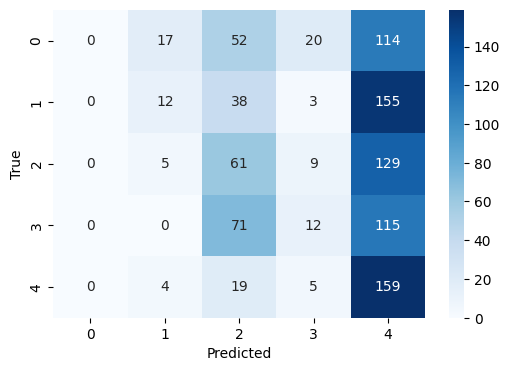

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
